# Matching

In [1]:
import numpy as np
import uproot
import vector
import awkward
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import itertools

directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
#directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Functions and Maps

In [74]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None, weight_array=None, x_units='GeV'):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        errors = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(awkward.to_numpy(data[i]))
            hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
            hist.fill(data[i], weight=weight_array[i]) if weight_array is not None else hist.fill(data[i])
            norm_factor = np.sum(hist.counts() * np.diff(hist.axes[0].edges))
            if density: hep.histplot(hist.counts()/norm_factor, hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances())/norm_factor,label=data_label[i], histtype='step')
            else: hep.histplot(hist.counts(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()),label=data_label[i], histtype='step')
            counts.append(hist.counts()/norm_factor) if density else counts.append(hist.counts())
            errors.append(np.sqrt(hist.variances())/norm_factor) if density else errors.append(np.sqrt(hist.variances()))       
    else:
        hist = bh.Histogram(bh.axis.Regular(bins, global_min, global_max))
        hist.fill(data[i])
        hep.histplot(hist.view(), hist.axes[0].edges, ax=axes, yerr=np.sqrt(hist.variances()), label=data_label, histtype='step')

    bin_width = hist.axes[0].edges[1]-hist.axes[0].edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2g} {x_units}')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            ratio_errors = np.sqrt(np.divide(errors[i],counts[i], out=np.zeros_like(counts[i]), where=counts[i]!=0)**2 + (np.divide(errors[0],counts[0], out=np.zeros_like(counts[0]), where=counts[0]!=0)**2))
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, yerr=ratio_errors, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

def n_combinations(particles, n, dictionary, type):
    i = n
    while len(particles[awkward.num(particles)>=i])!=0:
        particles_i = particles[awkward.num(particles)==i]
        if len(particles_i)==0:
            i+=1
            continue
        indices = np.array(list(itertools.combinations(range(np.shape(particles_i)[1]), n)))
        dictionary[type+f'_{i}'] = particles_i[:, indices]
        i += 1
    return None

def truth_matching(reco, truth):
    id = np.tile(np.arange(1,len(truth[0])+1), (len(truth),1))
    pairs_2d = awkward.cartesian({'reco':reco,'truth':truth})
    id_pairs_2d = awkward.cartesian({'reco':reco,'id':id})
    pairs_3d = awkward.unflatten(pairs_2d, len(truth[0]), axis=1)
    id_pairs_3d = awkward.unflatten(id_pairs_2d, len(truth[0]), axis=1)

    deltars = pairs_3d['reco'].deltaR(pairs_3d['truth'])
    min_deltars = np.min(deltars, axis=2)
    id_pairs_3d = id_pairs_3d[(deltars == min_deltars)]
    id_pairs_3d = id_pairs_3d[min_deltars<0.4]

    return id_pairs_3d

mass_lookup = {
    1: 2.16E-3,
    2: 4.7E-3,
    3: 1.273,
    4: 93.5E-3,
    5: 172.57,
    6: 4.183,
    11: 0.511E-3,
    12: 0,
    13: 105.66E-3,
    14: 0,
    15: 1.77693,
    16: 0,
    21: 0
}

## Data

### 4 Top Matching

In [3]:
tree4 = uproot.open(directory + "4tops_withtruth_oct24.root")
events_4t_jets = tree4["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_4t_electrons = tree4["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_4t_muons = tree4["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_4t_neutrinos = tree4["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_4t_truth = tree4['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_4t_truth = events_4t_truth[(events_4t_truth['Particle.Status']==23)]

events_4t_electrons['Electron.Mass'] = np.ones_like(events_4t_electrons['Electron.PT']) * 0.511E-3
events_4t_muons['Muon.Mass'] = np.ones_like(events_4t_muons['Muon.PT']) * 105.7E-3

jets_pt_4t = events_4t_jets['Jet.PT'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_eta_4t = events_4t_jets['Jet.Eta'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_phi_4t = events_4t_jets['Jet.Phi'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]
jets_mass_4t = events_4t_jets['Jet.Mass'][(events_4t_jets['Jet.Eta']<2.5) & (events_4t_jets['Jet.Eta']>-2.5)]

electrons_pt_4t = events_4t_electrons['Electron.PT'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_eta_4t = events_4t_electrons['Electron.Eta'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_phi_4t = events_4t_electrons['Electron.Phi'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]
electrons_mass_4t = events_4t_electrons['Electron.Mass'][(events_4t_electrons['Electron.PT'] > 15) & (events_4t_electrons['Electron.Eta'] < 2.47) & (events_4t_electrons['Electron.Eta'] > -2.47)]

muons_pt_4t = events_4t_muons['Muon.PT'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_eta_4t = events_4t_muons['Muon.Eta'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_phi_4t = events_4t_muons['Muon.Phi'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]
muons_mass_4t = events_4t_muons['Muon.Mass'][(events_4t_muons['Muon.PT']>15) & (events_4t_muons['Muon.Eta']<2.5) & (events_4t_muons['Muon.Eta']>-2.5)]

reco_pt_4t = awkward.concatenate((jets_pt_4t,electrons_pt_4t,muons_pt_4t), axis=1)
reco_eta_4t = awkward.concatenate((jets_eta_4t,electrons_eta_4t,muons_eta_4t), axis=1)
reco_phi_4t = awkward.concatenate((jets_phi_4t,electrons_phi_4t,muons_phi_4t), axis=1)
reco_mass_4t = awkward.concatenate((jets_mass_4t,electrons_mass_4t,muons_mass_4t), axis=1)

truth_pt_4t = events_4t_truth['Particle.PT']
truth_eta_4t = events_4t_truth['Particle.Eta']
truth_phi_4t = events_4t_truth['Particle.Phi']
truth_mass_4t = events_4t_truth['Particle.Mass']

reco_4t = vector.zip({'pt':reco_pt_4t,'eta':reco_eta_4t,'phi':reco_phi_4t,'mass':reco_mass_4t})
truth_4t = vector.zip({'pt':truth_pt_4t,'eta':truth_eta_4t,'phi':truth_phi_4t,'mass':truth_mass_4t})

In [78]:
reco_4t_test = reco_4t[(awkward.num(reco_4t)!=0)&(awkward.num(truth_4t)!=0)]
truth_4t_test = truth_4t[(awkward.num(reco_4t)!=0)&(awkward.num(truth_4t)!=0)]

truth_4t_12 = truth_4t[awkward.num(truth_4t)==12]
reco_4t_12 = reco_4t[awkward.num(truth_4t)==12]

truth_4t_13 = truth_4t[awkward.num(truth_4t)==13]
truth_4t_13 = truth_4t_13[:,1:]
reco_4t_13 = reco_4t[awkward.num(truth_4t)==13]

truth_4t_test = awkward.concatenate((truth_4t_12, truth_4t_13))
reco_4t_test = awkward.concatenate((reco_4t_12, reco_4t_13))

id_pairs_4t = truth_matching(reco_4t_test, truth_4t_test)

top_1_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==1)|(id_pairs_4t['id']==5)|(id_pairs_4t['id']==9)]
top_2_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==2)|(id_pairs_4t['id']==6)|(id_pairs_4t['id']==10)]
antitop_1_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==3)|(id_pairs_4t['id']==7)|(id_pairs_4t['id']==11)]
antitop_2_4t = id_pairs_4t['reco'][(id_pairs_4t['id']==4)|(id_pairs_4t['id']==8)|(id_pairs_4t['id']==12)]

top_1_4t = top_1_4t[awkward.num(top_1_4t, axis=2)!=0]
top_2_4t = top_2_4t[awkward.num(top_2_4t, axis=2)!=0]
antitop_1_4t = antitop_1_4t[awkward.num(antitop_1_4t, axis=2)!=0]
antitop_2_4t = antitop_2_4t[awkward.num(antitop_2_4t, axis=2)!=0]

### 3 Top Matching

['Event', 'Event/Event.fUniqueID', 'Event/Event.fBits', 'Event/Event.Number', 'Event/Event.ReadTime', 'Event/Event.ProcTime', 'Event/Event.ProcessID', 'Event/Event.MPI', 'Event/Event.Weight', 'Event/Event.CrossSection', 'Event/Event.CrossSectionError', 'Event/Event.Scale', 'Event/Event.AlphaQED', 'Event/Event.AlphaQCD', 'Event/Event.ID1', 'Event/Event.ID2', 'Event/Event.X1', 'Event/Event.X2', 'Event/Event.ScalePDF', 'Event/Event.PDF1', 'Event/Event.PDF2', 'Particle', 'Particle/Particle.fUniqueID', 'Particle/Particle.fBits', 'Particle/Particle.PID', 'Particle/Particle.Status', 'Particle/Particle.IsPU', 'Particle/Particle.M1', 'Particle/Particle.M2', 'Particle/Particle.D1', 'Particle/Particle.D2', 'Particle/Particle.Charge', 'Particle/Particle.Mass', 'Particle/Particle.E', 'Particle/Particle.Px', 'Particle/Particle.Py', 'Particle/Particle.Pz', 'Particle/Particle.P', 'Particle/Particle.PT', 'Particle/Particle.Eta', 'Particle/Particle.Phi', 'Particle/Particle.Rapidity', 'Particle/Particle.T', 'Particle/Particle.X', 'Particle/Particle.Y', 'Particle/Particle.Z', 'Jet', 'Jet/Jet.fUniqueID', 'Jet/Jet.fBits', 'Jet/Jet.T',', 'Jet/Jet.DeltaEta', 'Jet/Jet.DeltaPhi', 'Jet/Jet.Flavor', 'Jet/Jet.FlavorAlgo', 'Jet/Jet.FlavorPhys', 'Jet/Jet.BTagAlgo', 'Jet/Jet.BTagPhys', 'Jet/Jet.TauTag', 'Jet/Jet.TauWeight', 'Jet/Jet.Charge', 'Jet/Jet.EhadOverEem', 'Jet/Jet.NCharged', 'Jet/Jet.NNeutrals', 'Jet/Jet.NeutralEnergyFraction', 'Jet/Jet.ChargedEnergyFraction', 'Jet/Jet.Beta', 'Jet/Jet.BetaStar', 'Jet/Jet.MeanSqDeltaR', 'Jet/Jet.PTD', 'Jet/Jet.SoftDroppedJet', 'Jet/Jet.SoftDroppedSubJet1', 'Jet/Jet.SoftDroppedSubJet2', 'Jet/Jet.NSubJetsTrimmed', 'Jet/Jet.NSubJetsPruned', 'Jet/Jet.NSubJetsSoftDropped', 'Jet/Jet.ExclYmerge23', 'Jet/Jet.ExclYmerge34', 'Jet/Jet.ExclYmerge45', 'Jet/Jet.ExclYmerge56', 'Jet/Jet.Constituents', 'Jet/Jet.Particles', 'Jet/Jet.Area', 'Electron', 'Electron/Electron.fUniqueID', 'Electron/Electron.fBits', 'Electron/Electron.T', 'Electron/Electron.Charge', 'Electron/Electron.EhadOverEem', 'Electron/Electron.Particle', 'Electron/Electron.IsolationVar', 'Electron/Electron.IsolationVarRhoCorr', 'Electron/Electron.SumPtCharged', 'Electron/Electron.SumPtNeutral', 'Electron/Electron.SumPtChargedPU', 'Electron/Electron.SumPt', 'Electron/Electron.D0', 'Electron/Electron.DZ', 'Electron/Electron.ErrorD0', 'Electron/Electron.ErrorDZ', 'Muon', 'Muon/Muon.fUniqueID', 'Muon/Muon.fBits', 'Muon/Muon.T', 'Muon/Muon.Charge', 'Muon/Muon.Particle', 'Muon/Muon.IsolationVar', 'Muon/Muon.IsolationVarRhoCorr', 'Muon/Muon.SumPtCharged', 'Muon/Muon.SumPtNeutral', 'Muon/Muon.SumPtChargedPU', 'Muon/Muon.SumPt', 'Muon/Muon.D0', 'Muon/Muon.DZ', 'Muon/Muon.ErrorD0', 'Muon/Muon.ErrorDZ', 'MissingET', 'MissingET/MissingET.fUniqueID', 'MissingET/MissingET.fBits']


In [42]:
tree3j = uproot.open(directory + "tttj_skimmed_2810_withtruth_0.root")
events_3tj_jets = tree3j["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tj_electrons = tree3j["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tj_muons = tree3j["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tj_neutrinos = tree3j["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tj_truth = tree3j['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tj_truth = events_3tj_truth[(events_3tj_truth['Particle.Status']==23)]

events_3tj_electrons['Electron.Mass'] = np.ones_like(events_3tj_electrons['Electron.PT']) * 0.511E-3
events_3tj_muons['Muon.Mass'] = np.ones_like(events_3tj_muons['Muon.PT']) * 105.7E-3

jets_pt_3tj = events_3tj_jets['Jet.PT'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_eta_3tj = events_3tj_jets['Jet.Eta'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_phi_3tj = events_3tj_jets['Jet.Phi'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]
jets_mass_3tj = events_3tj_jets['Jet.Mass'][(events_3tj_jets['Jet.Eta']<2.5) & (events_3tj_jets['Jet.Eta']>-2.5)]

electrons_pt_3tj = events_3tj_electrons['Electron.PT'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tj = events_3tj_electrons['Electron.Eta'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tj = events_3tj_electrons['Electron.Phi'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tj = events_3tj_electrons['Electron.Mass'][(events_3tj_electrons['Electron.PT'] > 15) & (events_3tj_electrons['Electron.Eta'] < 2.47) & (events_3tj_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tj = events_3tj_muons['Muon.PT'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_eta_3tj = events_3tj_muons['Muon.Eta'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_phi_3tj = events_3tj_muons['Muon.Phi'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]
muons_mass_3tj = events_3tj_muons['Muon.Mass'][(events_3tj_muons['Muon.PT']>15) & (events_3tj_muons['Muon.Eta']<2.5) & (events_3tj_muons['Muon.Eta']>-2.5)]

reco_pt_3tj = awkward.concatenate((jets_pt_3tj,electrons_pt_3tj,muons_pt_3tj), axis=1)
reco_eta_3tj = awkward.concatenate((jets_eta_3tj,electrons_eta_3tj,muons_eta_3tj), axis=1)
reco_phi_3tj = awkward.concatenate((jets_phi_3tj,electrons_phi_3tj,muons_phi_3tj), axis=1)
reco_mass_3tj = awkward.concatenate((jets_mass_3tj,electrons_mass_3tj,muons_mass_3tj), axis=1)

truth_pt_3tj = events_3tj_truth['Particle.PT']
truth_eta_3tj = events_3tj_truth['Particle.Eta']
truth_phi_3tj = events_3tj_truth['Particle.Phi']
truth_mass_3tj = events_3tj_truth['Particle.Mass']

reco_3tj = vector.zip({'pt':reco_pt_3tj,'eta':reco_eta_3tj,'phi':reco_phi_3tj,'mass':reco_mass_3tj})
truth_3tj = vector.zip({'pt':truth_pt_3tj,'eta':truth_eta_3tj,'phi':truth_phi_3tj,'mass':truth_mass_3tj})

reco_3tj = reco_3tj[(awkward.num(reco_3tj)!=0)&(awkward.num(truth_3tj)!=0)]
truth_3tj = truth_3tj[(awkward.num(reco_3tj)!=0)&(awkward.num(truth_3tj)!=0)]

In [77]:
truth_3tj_test = truth_3tj[awkward.num(truth_3tj)==10]
reco_3tj_test = reco_3tj[awkward.num(truth_3tj)==10]

id_pairs_3tj = truth_matching(reco_3tj_test, truth_3tj_test)

jet_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==1)]
top_1_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==2)|(id_pairs_3tj['id']==5)|(id_pairs_3tj['id']==8)]
top_2_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==3)|(id_pairs_3tj['id']==6)|(id_pairs_3tj['id']==9)]
top_3_3tj = id_pairs_3tj['reco'][(id_pairs_3tj['id']==4)|(id_pairs_3tj['id']==7)|(id_pairs_3tj['id']==10)]

jet_3tj = jet_3tj[awkward.num(jet_3tj, axis=2)!=0]
top_1_3tj = top_1_3tj[awkward.num(top_1_3tj, axis=2)!=0]
top_2_3tj = top_2_3tj[awkward.num(top_2_3tj, axis=2)!=0]
top_3_3tj = top_3_3tj[awkward.num(top_3_3tj, axis=2)!=0]

In [ ]:
tree3W = uproot.open(directory + "tttW_skim_with_truth_2810_0.root")
events_3tW_jets = tree3W["Delphes;1"]["Jet"].arrays(['Jet.PT','Jet.Eta','Jet.Phi','Jet.Mass','Jet.BTag'])
events_3tW_electrons = tree3W["Delphes;1"]["Electron"].arrays(['Electron.PT','Electron.Eta','Electron.Phi'])
events_3tW_muons = tree3W["Delphes;1"]["Muon"].arrays(['Muon.PT','Muon.Eta','Muon.Phi'])
events_3tW_neutrinos = tree3W["Delphes;1"]['MissingET'].arrays(['MissingET.MET', 'MissingET.Eta', 'MissingET.Phi'])
events_3tW_truth = tree3W['Delphes;1']['Particle'].arrays(['Particle.PID','Particle.Status','Particle.Mass','Particle.PT','Particle.Eta','Particle.Phi'])
events_3tW_truth = events_3tW_truth[(events_3tW_truth['Particle.Status']==23)]

events_3tW_electrons['Electron.Mass'] = np.ones_like(events_3tW_electrons['Electron.PT']) * 0.511E-3
events_3tW_muons['Muon.Mass'] = np.ones_like(events_3tW_muons['Muon.PT']) * 105.7E-3

jets_pt_3tW = events_3tW_jets['Jet.PT'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_eta_3tW = events_3tW_jets['Jet.Eta'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_phi_3tW = events_3tW_jets['Jet.Phi'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]
jets_mass_3tW = events_3tW_jets['Jet.Mass'][(events_3tW_jets['Jet.Eta']<2.5) & (events_3tW_jets['Jet.Eta']>-2.5)]

electrons_pt_3tW = events_3tW_electrons['Electron.PT'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_eta_3tW = events_3tW_electrons['Electron.Eta'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_phi_3tW = events_3tW_electrons['Electron.Phi'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]
electrons_mass_3tW = events_3tW_electrons['Electron.Mass'][(events_3tW_electrons['Electron.PT'] > 15) & (events_3tW_electrons['Electron.Eta'] < 2.47) & (events_3tW_electrons['Electron.Eta'] > -2.47)]

muons_pt_3tW = events_3tW_muons['Muon.PT'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_eta_3tW = events_3tW_muons['Muon.Eta'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_phi_3tW = events_3tW_muons['Muon.Phi'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]
muons_mass_3tW = events_3tW_muons['Muon.Mass'][(events_3tW_muons['Muon.PT']>15) & (events_3tW_muons['Muon.Eta']<2.5) & (events_3tW_muons['Muon.Eta']>-2.5)]

reco_pt_3tW = awkward.concatenate((jets_pt_3tW,electrons_pt_3tW,muons_pt_3tW), axis=1)
reco_eta_3tW = awkward.concatenate((jets_eta_3tW,electrons_eta_3tW,muons_eta_3tW), axis=1)
reco_phi_3tW = awkward.concatenate((jets_phi_3tW,electrons_phi_3tW,muons_phi_3tW), axis=1)
reco_mass_3tW = awkward.concatenate((jets_mass_3tW,electrons_mass_3tW,muons_mass_3tW), axis=1)

truth_pt_3tW = events_3tW_truth['Particle.PT']
truth_eta_3tW = events_3tW_truth['Particle.Eta']
truth_phi_3tW = events_3tW_truth['Particle.Phi']
truth_mass_3tW = events_3tW_truth['Particle.Mass']

reco_3tW = vector.zip({'pt':reco_pt_3tW,'eta':reco_eta_3tW,'phi':reco_phi_3tW,'mass':reco_mass_3tW})
truth_3tW = vector.zip({'pt':truth_pt_3tW,'eta':truth_eta_3tW,'phi':truth_phi_3tW,'mass':truth_mass_3tW})

reco_3tW = reco_3tW[(awkward.num(reco_3tW)!=0)&(awkward.num(truth_3tW)!=0)]
truth_3tW = truth_3tW[(awkward.num(reco_3tW)!=0)&(awkward.num(truth_3tW)!=0)]

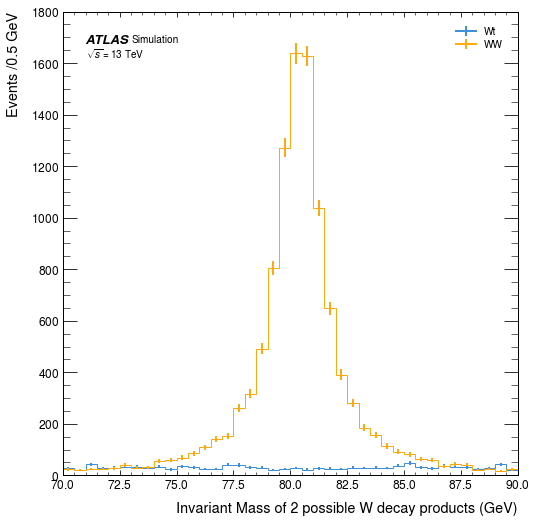

In [75]:
reco_3tW_test = reco_3tW[awkward.num(truth_3tW)==11]
truth_3tW_test = truth_3tW[awkward.num(truth_3tW)==11]

W1_Wt = truth_3tW_test[:,3]
W2_Wt = truth_3tW_test[:,7]

W1_WW = truth_3tW_test[:,3]
W2_WW = truth_3tW_test[:,4]

W_Wt_total_4 = W1_Wt + W2_Wt

W_WW_total_4 = W1_WW + W2_WW

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
histogram([W_Wt_total_4.m, W_WW_total_4.m], 40, ['Wt', 'WW'], ax, density = False, x_units='GeV', set_range=(70,90))
ax.set_xlabel(r'Invariant Mass of 2 possible W decay products (GeV)')
plt.subplots_adjust(hspace=0.25)
plt.show()

In [76]:
id_pairs_3tW = truth_matching(reco_3tW_test, truth_3tW_test)

top_1_3tW = id_pairs_3tj['reco'][(id_pairs_3tj['id']==1)|(id_pairs_3tj['id']==5)|(id_pairs_3tj['id']==9)]
top_2_3tW = id_pairs_3tj['reco'][(id_pairs_3tj['id']==2)|(id_pairs_3tj['id']==6)|(id_pairs_3tj['id']==10)]
top_3_3tW = id_pairs_3tj['reco'][(id_pairs_3tj['id']==3)|(id_pairs_3tj['id']==7)|(id_pairs_3tj['id']==11)]
W_3tW = id_pairs_3tj['reco'][(id_pairs_3tj['id']==4)|(id_pairs_3tj['id']==8)]

top_1_3tW = top_1_3tW[awkward.num(top_1_3tW, axis=2)!=0]
top_2_3tW = top_2_3tW[awkward.num(top_2_3tW, axis=2)!=0]
top__3tW = top_3_3tW[awkward.num(top_1_3tW, axis=2)!=0]
W_3tW = W_3tW[awkward.num(W_3tW, axis=2)!=0]

# Possible Code for use later

In [ ]:
truth_level_numbers = list(dict.fromkeys(awkward.num(truth_4t_test)))

truth_4t_dict = {}
reco_4t_dict = {}

for truth_number in truth_level_numbers:
    truth_4t_dict[f'truth_particles_{truth_number}'] = truth_4t_test[awkward.num(truth_4t_test)==truth_number]
    reco_4t_dict[f'truth_particles_{truth_number}'] = reco_4t_test[awkward.num(truth_4t_test)==truth_number]

for key in truth_4t_dict.keys():
    truth_particles = truth_4t_dict[key]
    reco_particles = reco_4t_dict[key]
    num = awkward.num(truth_particles)[0]
    pairs = awkward.cartesian({'truth':truth_particles,'reco':reco_particles})
    pairs = awkward.unflatten(pairs, num, axis=1)
    deltars = pairs['reco'].deltaR(pairs['truth'])
    print(np.shape(pairs['truth'][1]))
    pairs = pairs[deltars == np.min(deltars, axis=1)]
    deltars = np.min(deltars, axis=1)
    pairs = pairs[deltars<0.4]
    print('Next Key')